<a href="https://colab.research.google.com/github/lauramartinezes/outlier_detection/blob/main/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier detection

## Instructions
"*A small dataset (...) contains ‘good’ images and two types of outliers. The task is to detect outliers in the dataset – you are free to select your choice of method.*"

## The Dataset
180 Image Dataset.svg

*Fig. 1 Dataset distribution*

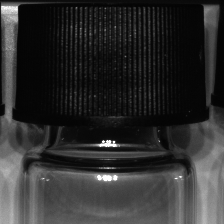
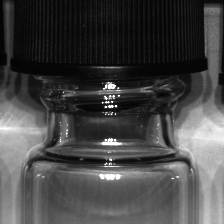
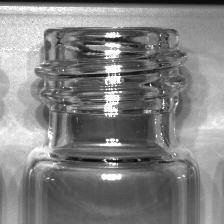

*Fig. 2 Samples from better to worse*

## The Tools

tools.svg

*Fig. 3 Tools*

## The Method: Autoencoder for outlier detection

autoencoder.svg

*Fig. 4 Autoencoder architecture*

## Colab preparation





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/outlier_detection"

/content/drive/MyDrive/Colab Notebooks/outlier_detection


In [ ]:
!pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from alibi_detect.od import OutlierAE
from PIL import Image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from typing import Dict

## Data loading

### Functions

In [ ]:
SIZE = 64

def load_dataset(image_directory, file_type="bmp"):
  images = os.listdir(image_directory)
  dataset = [] 
  for i, image_name in enumerate(images):
      if (image_name.split('.')[1] == file_type):
          image = cv2.imread(image_directory + image_name)
          image = Image.fromarray(image, 'RGB')
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))

  return np.array(dataset)

In [ ]:
def split_dataset(dataset, train_percentage, validation_percentage):
  permuted_dataset = np.random.permutation(dataset)

  len_train_set = round(len(permuted_dataset)*train_percentage)
  len_validation_set = round(len(permuted_dataset)*validation_percentage)

  train = permuted_dataset[0:len_train_set]
  validation = permuted_dataset[len_train_set:len_train_set+len_validation_set]
  test = permuted_dataset[len_train_set+len_validation_set:len(permuted_dataset)]

  return train, validation, test

In [ ]:
def normalize_dataset(dataset):
  return dataset.astype('float32') / 255.

### Good data
The dataset containing good images is loaded and divided into:
*   70% training
*   20% validation
*   10% testing

In [ ]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/outlier_detection/images/train/'

good_dataset = load_dataset(image_directory + 'good/')

In [ ]:
good_dataset_train, good_dataset_validation, good_dataset_test = split_dataset(good_dataset, 0.7, 0.2)

good_dataset_train = normalize_dataset(good_dataset_train)
good_dataset_validation = normalize_dataset(good_dataset_validation)
good_dataset_test = normalize_dataset(good_dataset_test)

### Bad data and very bad data
Our two types of outliers are used during the testing step

In [ ]:
bad_dataset = load_dataset(image_directory + 'bad/')
bad_dataset = normalize_dataset(bad_dataset)

very_bad_dataset = load_dataset(image_directory + 'very_bad/')
very_bad_dataset = normalize_dataset(very_bad_dataset)

## Define encoder and decoder networks

In [ ]:
encoding_dim = 1024  #dimension of the compressed vector
dense_dim = [8, 8, 512] #dimension of the last conv. output

### Encoder

In [ ]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=good_dataset_train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


### Decoder

In [ ]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

## Define outlier detector

In [ ]:
outlier_detector_model = OutlierAE(
    threshold=.015,
    encoder_net=encoder_net,  
    decoder_net=decoder_net
    )  

print("Current threshold value is: ", outlier_detector_model.threshold)

Current threshold value is:  0.015


## Train

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
mse = tf.keras.losses.MeanSquaredError()
outlier_detector_model.fit(good_dataset_train, loss_fn=mse, optimizer = adam, epochs=100, batch_size=4, verbose=True)

print("\nCurrent threshold value is: ", outlier_detector_model.threshold)

26/26 [=] - 1s 29ms/step - loss_ma: 2.5816e-04

Current threshold value is:  0.015


## Infer threshold from validation data

In [ ]:
outlier_detector_model.infer_threshold(
    good_dataset_validation, 
    outlier_type='instance', 
    outlier_perc=90.0,
    threshold_perc=100.0
    )
print("Current threshold value is: ", outlier_detector_model.threshold)

Current threshold value is:  0.0015565379289910197


## Plot reconstruction examples from test data

### Functions

In [ ]:
def plt_row(original_dataset, reconstructed_dataset, row_title, random_sample=0):
  fig, axs = plt.subplots(1, 2, figsize=(8,8))
  fig.suptitle(row_title + " [" + str(random_sample) + "]", y=0.75, fontsize=16)
  axs[0].imshow(original_dataset[random_sample],'gray')
  axs[0].axis('off')
  axs[0].set_title("Input data")

  axs[1].imshow(reconstructed_dataset[random_sample],'gray')
  axs[1].axis('off')
  axs[1].set_title("Reconstructed data")

In [ ]:
def get_random_element(dataset):
  return random.randint(0, len(dataset)-1)

### Plot

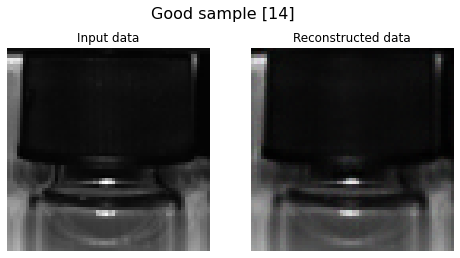

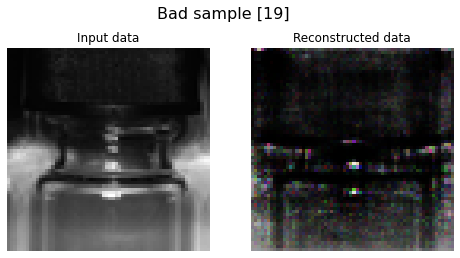

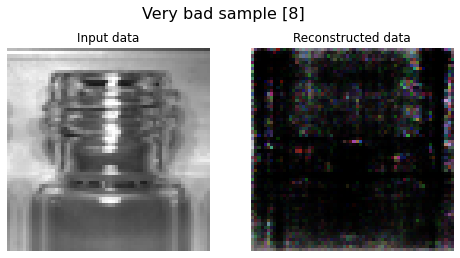

In [ ]:
good_dataset_test_reconstructed = outlier_detector_model.ae(good_dataset_test).numpy()
bad_dataset_reconstructed = outlier_detector_model.ae(bad_dataset).numpy()
very_bad_dataset_reconstructed = outlier_detector_model.ae(very_bad_dataset).numpy()

plt_row(good_dataset_test, good_dataset_test_reconstructed, 'Good sample', get_random_element(good_dataset_test))
plt_row(bad_dataset, bad_dataset_reconstructed, 'Bad sample', get_random_element(bad_dataset))
plt_row(very_bad_dataset, very_bad_dataset_reconstructed, 'Very bad sample', get_random_element(very_bad_dataset))
plt.show()

*Fig. 5 Reconstruction examples*

## Get predictions from test set

### Functions

In [ ]:
# Set target scores (1 for bad images and 0 for good images)
def get_target_scores(dataset, outlier=True):
  if outlier:
    return np.ones(dataset.shape[0],).astype(int)
  return np.zeros(dataset.shape[0],).astype(int)

In [ ]:
def plot_instance_score(preds: Dict,
                        target: np.ndarray,
                        threshold: float,
                        ylim: tuple = (None, None)) -> None:
    labels = ['Good sample', 'Bad sample', "Very bad sample"]
    scores = preds['data']['instance_score']
    df = pd.DataFrame(dict(idx=np.arange(len(scores)), score=scores, label=target))
    groups = df.groupby('label')
    fig, ax = plt.subplots(figsize=(20,8))
    for name, group in groups:
        ax.plot(group.idx, group.score, marker='+', linestyle='', ms=10, label=labels[name])
    plt.plot(np.arange(len(scores)), np.ones(len(scores)) * threshold, color='g', label='Threshold')
    plt.ylim(ylim)
    plt.xlabel('Instances (Images)', fontsize=14)
    plt.ylabel('Instace Scores', fontsize=14)
    plt.title('Outlier detection', fontsize=20)
    ax.legend(prop={"size":14})
    plt.show()

### Result

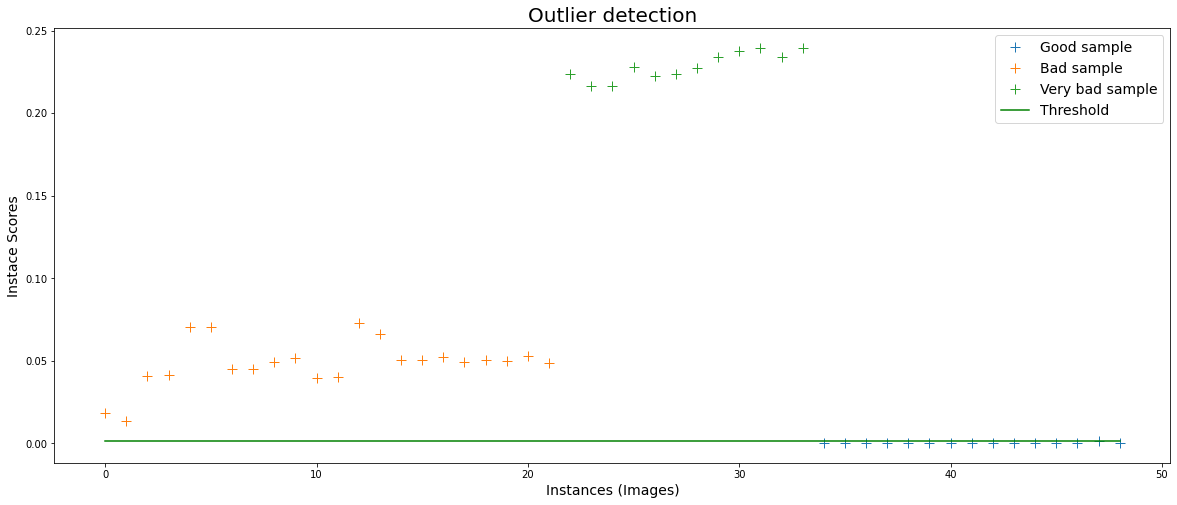


Lowest outlier score        0.013741302 
Threshold                   0.0015565379289910197 
Highest good sample score   0.001399383


In [ ]:
final_test_dataset = np.concatenate((bad_dataset, very_bad_dataset, good_dataset_test), axis=0)
all_data_predictions = outlier_detector_model.predict(final_test_dataset, outlier_type='instance', return_instance_score=True)

target_bad = get_target_scores(bad_dataset)
target_very_bad = get_target_scores(very_bad_dataset)*2
target_good = get_target_scores(good_dataset_test, outlier=False)
target_all = np.concatenate((target_bad, target_very_bad, target_good), axis=0)

plot_instance_score(all_data_predictions, target_all, outlier_detector_model.threshold)

maximum_score_good_sample = np.max(all_data_predictions["data"]['instance_score'][len(bad_dataset)+len(very_bad_dataset):])
minimum_score_outlier = np.min(all_data_predictions["data"]['instance_score'][:len(bad_dataset)+len(very_bad_dataset)])
print("\nLowest outlier score       ", minimum_score_outlier, "\nThreshold                  ",outlier_detector_model.threshold, "\nHighest good sample score  ", maximum_score_good_sample)

*Fig. 6 Results*